**Dans ce chapitre, j'utilise la photo d'un paon blanc pour tester le programme (en remplacement de celle du "pig" initiale).**

**Je constate que le bruit ne marche pas si bien que sur la photo du cochon : j'ai du l'augmenter de 2/255 à 4/255 pour parvenir à ce qu'il ne soit plus classifié comme "paon".**

**Je me suis demandée si cette difficulté plus grande était liée à la probabilité de bonne classification de l'image, bien plus faible que celle du cochon (0.38 contre 0.99). J'ai donc également pris la photo d'un paon "normal", pour comparer.**

**A ma surprise, bien que ce paon "normal" ait une probabilité de bonne classification de 0.99, les difficultés ont été encore plus grandes à leurrer le classifieur. Augmenter le bruit n'a pas suffi : j'ai donc finalement laissé le bruit tel quel et augmenté le nombre d'itérations, en le passant de 30 à 100 itérations, pour enfin parvenir à leurrer le classifieur sur cette image.**

**Je me demande (sans avoir trouvé de réponse) ce qui explique cette difficulté plus grande à leurrer le classifieur sur ces deux images-ci**


**Dans la suite du chapitre, mes commentaires sont en gras - et ceux déjà présents auparavant sont, pour l'essentiel, laissés en place.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
### PREAMBLE
# Chapter 1 - Introduction to adversarial robustness
# noise.jpg

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Préparation de l'image :


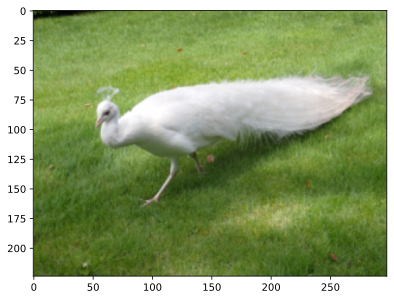

In [ ]:
from PIL import Image
from torchvision import transforms

# read the image, resize to 224 and convert to PyTorch Tensor
photo_img = Image.open("/content/drive/MyDrive/donnees/paon.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
photo_tensor = preprocess(photo_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(photo_tensor[0].numpy().transpose(1,2,0))

# Chargement du modèle pré-entraîné ResNet50, et application de ce modèle à notre image :

Ce modèle est une version du réseau de neurones ResNet (Residual Networks) qui a été préalablement entraîné sur un vaste ensemble de données, à savoir ImageNet, pour résoudre des tâches de classification d'images.
ResNet est une architecture de réseau de neurones profonde qui a introduit un concept clé : les connexions résiduelles (residual connections). Ces connexions permettent de "sauter" certaines couches dans le réseau, ce qui aide à résoudre le problème de l'explosion ou de la disparition des gradients dans les réseaux très profonds (c'est-à-dire les réseaux avec de nombreuses couches).

Le nombre 50 fait référence au nombre de couches dans le modèle : ResNet-50 contient 50 couches. Ce modèle est une version "plus légère" par rapport à des versions comme ResNet-101 (101 couches) ou ResNet-152 (152 couches).

Les modèles ResNet sont composés de plusieurs blocs de couches appelés blocs résiduels. Chaque bloc inclut des convolutions, des activations et des connexions résiduelles.

ResNet-50 a environ 23 millions de paramètres, ce qui est relativement modéré pour un modèle profond, et permet de le déployer dans des applications avec des ressources limitées.

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images,
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();

In [ ]:
# form predictions
pred = model(norm(photo_tensor))

Pred contient maintenant un vecteur de 1000 dimensions contenant les logits de classe pour les 1000 classes imagenet (si vous voulez convertir cela en un vecteur de probabilité, vous appliqueriez donc l'opérateur softmax à ce vecteur). Pour trouver la classe ayant la probabilité la plus élevée, nous prenons simplement l'indice associé à la valeur maximale dans ce vecteur, et nous pouvons le rechercher dans une liste de classes imagenet pour trouver l'étiquette correspondante.


In [ ]:
import json
with open("/content/drive/MyDrive/donnees/imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print(imagenet_classes[pred.max(dim=1)[1].item()],pred.max(dim=1)[1].item())

peacock 84


Ces lignes de code nous permettent de voir à quelle classe ImageNet l'image appartient selon la prédiction du modèle en effectuant pour ce faire :

-Le chargement du fichier JSON qui associe les indices de classes ImageNet aux noms des classes.

-La récupération de l'indice de la classe avec la probabilité la plus élevée dans la sortie de prédiction pred.

-Puis l'affichage du nom de la classe correspondant à cet indice à partir du dictionnaire imagenet_classes.


### Tromper le classifieur

Maintenant essayons de tromper ce classificateur en lui faisant croire que cette image d'un paon est autre chose.
Nous définissons le modèle, ou fonction d'hypothèse, $h_\theta : \mathcal{X} \rightarrow \mathbb{R}^k$ comme l'application de l'espace d'entrée (dans l'exemple ci-dessus cet espace est un tenseur tridimensionnel), dans l'espace de sortie, qui est un vecteur k-dimensionnel, où k est le nombre de classes prédit.
Comme dans notre modèle ci-dessus, la sortie correspond à l'espace logit, de sorte qu'il s'agit de nombres réels qui peuvent être positifs ou négatifs. Le vecteur $y$ représente tous les paramètres définissant ce modèle (c'est-à-dire tous les filtres convolutifs, les matrices de poids de couche entièrement connectées, les biais, etc.); les paramètres de $\theta$ _y sont ceux que nous optimisons lorsque nous entrainons un réseau de neurones. $h_\theta$ correspond précisément à l'objet `model` dans le code Python ci-dessus.


Puis nous définissons une fonction de perte $\ell: \mathbb{R}^k \times \mathbb{Z}_+ \rightarrow \mathbb{R}_+$.

Le premier argument est la sortie du modèle (logits qui peuvent être positifs ou négatifs), et le second argument est l'indice de la classe vraie (c'est-à-dire un nombre de 1 à k désignant l'indice de l'étiquette vraie).

La fonction de perte la plus communément utilisée en deep learning est la cross-entropie (ou softmax loss) :

\begin{equation}
\ell(h_\theta(x), y) = \log \left ( \sum_{j=1}^k \exp(h_\theta(x)_j) \right ) - h_\theta(x)_y
\end{equation}

où $h_\theta(x)_j$ indique le $j$ème élément du vecteur $h_\theta(x)$.

L'objectif typique de l'entraînement d'un réseau de neurones est de maximiser la probabilité de l'étiquette de la classe réelle.

Du fait que les probabilités elles-mêmes deviennent faibles, il est plus fréquent de maximiser le log de la probabilité de l'étiquette de classe réelle, qui est donnée par

\begin{equation}
\log \sigma(h_\theta(x))_y = \log \left(\frac{exp(h_\theta(x)_y)}{\sum_{j=1}^{k}\exp(h_\theta(x)_{j})} \right) = h_\theta(x)_y - \log \left (\sum_{j=1}^{k}\exp(h_\theta(x)_{j}) \right ).
\end{equation}

La convention étant que nous cherchons à minimiser la perte (plutôt qu'à maximiser la vraisemblance), nous utilisons "moins" cette quantité comme fonction de perte.

Nous le faisons dans PyTorch en utilisant la commande suivante.

In [ ]:
# 341 is the class index corresponding to "hog" - and 84 is the one corresponding to our peacock
print(nn.CrossEntropyLoss()(model(norm(photo_tensor)),torch.LongTensor([84])).item())

0.9642236828804016


**Une perte de 0,96 reste - relativement - faible, et correspondrait à une probabilité d'$\exp(-0.96) \approx 0.38$ que le classificateur croie qu'il s'agit d'un paon.
C'est bien moins élevé que pour l'exemple du porc - mais notre paon est blanc, ce qui est atypique pour un paon, et peut expliquer cet affaiblissement.**

#Création d'un exemple adverse

Pour faire croire au classificateur qu'il s'agit d'une autre chose, au lieu de chercher à minimiser la perte moyenne sur un ensemble d'apprentissage $\{x_i \in \mathcal{X}, y_i \in \mathbb{Z}\}$, $i=1,\ldots,m$  
 que nous écrivons comme problème d'optimisation
\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_\theta \frac{1}{m} \sum_{i=1}^m \ell(h_\theta(x_i), y_i)
\end{equation}

nous allons ajuster l'image pour maximiser la perte. C'est-à-dire que nous voulons résoudre le problème d'optimisation
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\hat{x}} \ell(h_\theta(\hat{x}), y)
\end{equation}

où $\hat{x}$ désigne notre exemple adverse. Bien sûr, nous ne pouvons pas simplement optimiser arbitrairement sur $\hat{x}$ (il existe, après tout, certaines images qui *ne sont pas* des paons, et si nous changeons complètement l'image, par exemple en une photo de chien, alors ce n'est pas particulièrement impressionnant que nous puissions « tromper » le classificateur en pensant qu'il ne s'agit pas d'un paon). Donc, nous devons plutôt nous assurer que $\hat{x}$ est proche de notre entrée d'origine $x$.

Par convention, nous le faisons généralement en optimisant sur la _perturbation_ à $x$, que nous noterons $\delta$, puis en optimisant sur $\delta$

\begin{equation}
\maximize_{\delta \in \Delta} \ell(h_\theta(x +\delta), y)
\end{equation}


où $\Delta$ représente un ensemble admissible de perturbations. Il est en fait très difficile de caractériser l'ensemble des perturbations « correctes » : en théorie, nous voudrions que $\Delta$ capture tout ce que les humains ressentent visuellement comme "identique" de l'exemple $x$.

Cela peut inclure l'ajout de légères quantités de bruit, ou bien une rotation, une translation, un changement d'échelle ou une transformation 3D sur le modèle sous-jacent, ou même la modification complète de l'image dans les emplacements « non-paon ».
Il n'est, donc, pas possible de donner une définition mathématiquement rigoureuse de toutes les perturbations qui *peuvent* être autorisées.

Cependant, la philosophie est que nous pouvons considérer un sous-ensemble de l'espace possible des perturbations autorisées, de sorte que par une définition «raisonnable» réelle, le contenu sémantique réel de l'image ne pourrait pas changer sous cette perturbation.

Un ensemble de perturbation commun à utiliser, bien que n'étant pas le seul choix possible, est la boule $\ell_\infty$, définie par l'ensemble

\begin{equation}
\Delta = \{\delta : \|\delta\|_\infty \leq \epsilon\}
\end{equation}

avec :

\begin{equation}
\|z\|_\infty = \max_i |z_i|
\end{equation}

c'est-à-dire que nous laissons la perturbation avoir une grandeur entre $[-\epsilon, \epsilon]$, dans chacune de ses composantes (c'est un peu plus complexe, car il faut également s'assurer que $x + \delta$ est également borné entre $[0,1]$ - de sorte qu'il s'agisse toujours d'une image valide).

L'avantage de cette boule $\ell_\infty$ est que pour $\epsilon$ petit, on crée des perturbations qui ajoutent une composante si petite à chaque pixel dans l'image qu'elles sont visuellement impossibles à distinguer de l'image d'origine, et fournissent ainsi une condition « nécessaire mais pas suffisante » pour considérer un classificateur comme étant robuste aux perturbations.

Et la réalité est que les réseaux profonds peuvent très facilement être dupés par des manipulations de ce type précis.

L'exemple suivant utilise l'optimiseur `SGD` de PyTorch pour ajuster notre perturbation à l'input afin de maximiser la perte, mais on est en réalité dans une descente de gradient simple (car sans mini-batch et sans gradient stochastique).

Nous faisons suivre chaque étape par une projection sur la boule $\ell_\infty$  :  c'est donc en fait une procédure de descente de gradient projeté (DP).

**Cette méthode est un exemple d'attaque "Fast Gradient Sign Method" (FGSM) modifiée ou d'attaque par perturbation itérative sur un réseau de neurone.**

In [ ]:
import torch.optim as optim
epsilon = 2./255

delta = torch.zeros_like(photo_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(30):
    pred = model(norm(photo_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([84])) #84 : classe de mon image
    if t % 5 == 0:
        print(t, loss.item())

    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

print("True class probability:", nn.Softmax(dim=1)(pred)[0,84].item()) #84 : classe de mon image

0 -0.9642236828804016
5 -23.674816131591797
10 -23.664268493652344
15 -24.339487075805664
20 -27.92083740234375
25 -26.8653621673584
True class probability: 3.1948256540292874e-11


**Contrairement à la photo de cochon, ici, notre paon ("peacock") est toujours identifié comme tel (voir ci-dessous) : échec de notre exemple adverse !!**

**Même si après 30 itérations de descente du gradient, le modèle ResNet pense qu'il y a moins de $10^{-11}$ chance qu'il s'agisse d'un paon (si je lis bien le résultat ci-dessus).**

In [ ]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  Maltese_dog
Predicted probability: 0.9980497360229492


**On va donc réessayer de tromper le modèle, en changeant un peu le paramétrage pour la fabrication de notre exemple adverse, puisqu'il n'était pas suffisamment trompeur : je passe epsilon de 2/255 à 4/255 ci-dessous, c'est à dire j'augmente un peu l'ampleur du bruit.**

**Est-ce que cette fois-ci, nous allons réussir la tromperie ?**

In [ ]:
import torch.optim as optim
epsilon = 4./255

delta = torch.zeros_like(photo_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(30):
    pred = model(norm(photo_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([84])) #84 : classe de mon image
    if t % 5 == 0:
        print(t, loss.item())

    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

print("True class probability:", nn.Softmax(dim=1)(pred)[0,84].item()) #84 : classe de mon image

0 -0.9642236828804016
5 -27.042118072509766
10 -27.79244041442871
15 -32.48142623901367
20 -28.039352416992188
25 -35.67931365966797
True class probability: 1.9484109150310486e-13


**Cela fonctionne : notre paon est désormais identifié comme un dogue maltais (maltese dog) !**

**Cependant, il a fallu une probabilité de l'ordre de $10^{-13}$ pour y parvenir, tandis que pour l'image du cochon, une probabilité de l'ordre de $10^{-9}$ suffisait. La raison de cette différence est-elle liée à la probabilité, différente, de bonne identification de la photo d'origine (0.38 pour le paon blanc contre 0.99 pour le cochon) ?**

In [ ]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  Maltese_dog
Predicted probability: 0.9922027587890625


**Pour l'oeil humain, qu'est devenu notre paon blanc ?
Eh bien il ressemble toujours à un paon blanc.**

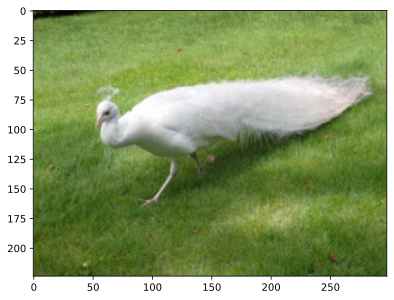

In [ ]:
plt.imshow((photo_tensor + delta)[0].detach().numpy().transpose(1,2,0))

**Voici le `delta` que nous avons ajouté à l'image, fortement zoomé d'un facteur
50 car il serait impossible de le voir autrement.**

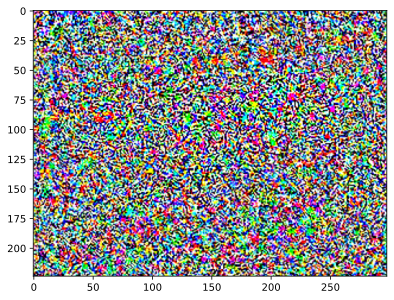

In [ ]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

Pour faire tout cela plus correctement, nous devrions quantifier notre bruit au niveau autorisé de l'image (c'est-à-dire à 1/255 près - et non 4/255 comme ici), mais des détails techniques comme celui-ci sont faciles à surmonter, et nous pouvons en effet créer des images valides qui sont impossibles à distinguer pour l'œil humain de notre image d'origine, cependant mal classifiés par le classificateur.

**J'ajoute un essai avec un paon "normal", ci-dessous.**

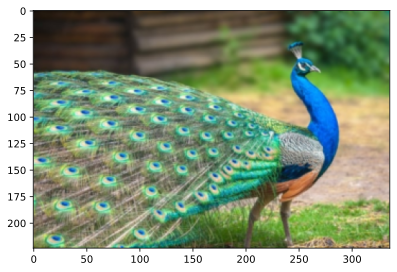

In [ ]:
from PIL import Image
from torchvision import transforms

# read the image, resize to 224 and convert to PyTorch Tensor
photo_img = Image.open("/content/drive/MyDrive/donnees/paon_c.jpeg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
photo_tensor = preprocess(photo_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(photo_tensor[0].numpy().transpose(1,2,0))

In [ ]:
# form predictions
pred = model(norm(photo_tensor))

In [ ]:
print(imagenet_classes[pred.max(dim=1)[1].item()],pred.max(dim=1)[1].item())

peacock 84


In [ ]:
# 341 is the class index corresponding to "hog" - and 84 is the one corresponding to our peacock
print(nn.CrossEntropyLoss()(model(norm(photo_tensor)),torch.LongTensor([84])).item())

0.000916537712328136


**Cette fois-ci, notre perte est de 0.0009, ce qui correspond à une probabilité de 0.99 que le classifieur reconnaisse notre nouveau paon comme tel - c'est très supérieur à celle pour notre paon blanc !**

In [ ]:
import torch.optim as optim
epsilon = 2./255

delta = torch.zeros_like(photo_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(30):
    pred = model(norm(photo_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([84])) #84 : classe de mon image
    if t % 5 == 0:
        print(t, loss.item())

    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

print("True class probability:", nn.Softmax(dim=1)(pred)[0,84].item()) #84 : classe de mon image

0 -0.000916537712328136
5 -0.0011252983240410686
10 -0.0014017528155818582
15 -0.0017960622208192945
20 -0.0024217821191996336
25 -0.003596268827095628
True class probability: 0.9945294260978699


**Mais ce n'est pas cette différence qui explique qu'il ait fallu plus de "bruit" que pour le cochon, pour leurrer le classificateur : en effet, malgré ce bruit, notre paon normal est toujours vu comme un paon.**

In [ ]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  peacock
Predicted probability: 0.9945294260978699


**Cette fois-ci, agir sur la taille d'epsilon n'a pas suffi : j'ai donc laissé epsilon à sa taille de départ, et agi sur le nombre d'itération de la descente de gradient, que j'ai augmenté, en le passant de 30 à 100 itérations - ce qui permet à notre paon "normal" d'être désormais identifié comme étant de la "laine" par le classifieur...**

In [ ]:
import torch.optim as optim
epsilon = 2./255

delta = torch.zeros_like(photo_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(100):
    pred = model(norm(photo_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([84])) #84 : classe de mon image
    if t % 10 == 0:
        print(t, loss.item())

    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

print("True class probability:", nn.Softmax(dim=1)(pred)[0,84].item()) #84 : classe de mon image

0 -0.000916537712328136
10 -0.0014017528155818582
20 -0.0024217821191996336
30 -0.0062445527873933315
40 -0.33780571818351746
50 -12.552691459655762
60 -15.906315803527832
70 -17.303443908691406
80 -18.6422061920166
90 -20.242277145385742
True class probability: 2.089506789815232e-09


In [ ]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  wool
Predicted probability: 0.9788080453872681


### Attaque adverse avec étiquette cible
Cette même technique peut être utilisée pour classer l'image dans pratiquement n'importe quelle classe souhaitée. C'est ce qu'on appelle une « attaque ciblée », et la seule différence est qu'au lieu d'essayer simplement de maximiser la perte de la bonne classe, nous maximisons la perte de la bonne classe tout en minimisant la perte de la classe cible. C'est-à-dire que nous résolvons le problème d'optimisation

\begin{equation}
\maximize_{\delta \in \Delta} \left (\ell(h_\theta(x +\delta), y) - \ell(h_\theta(x +\delta), y_{\mathrm{target}}) \right) \equiv \maximize_{\delta \in \Delta} \left(h_\theta(x+\delta)_{y_{\mathrm{target}}} - h_\theta(x+\delta)_{y} ]\right )
\end{equation}
où l'expression se simplifie car les termes $\log \left ( \sum_{j=1}^k \exp(h_\theta(x)_j) \right )$ de chaque perte s'annulent, et il ne reste que les termes linéaires.

Ci-dessous, nous avons légèrement ajusté la taille du pas pour que cela fonctionne dans ce cas, mais nous allons bientôt considérer des méthodes de mise à l'échelle légèrement différentes pour la descente de gradient projetée lorsque cela n'est pas nécessaire.

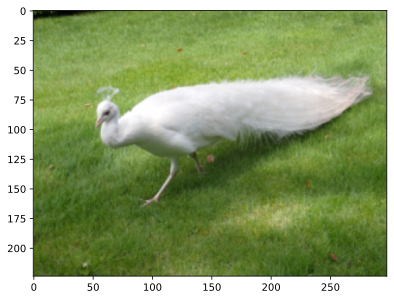

In [ ]:
from PIL import Image
from torchvision import transforms

# read the image, resize to 224 and convert to PyTorch Tensor
photo_img = Image.open("/content/drive/MyDrive/donnees/paon.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
photo_tensor = preprocess(photo_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(photo_tensor[0].numpy().transpose(1,2,0))

In [ ]:
delta = torch.zeros_like(photo_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

for t in range(100):
    pred = model(norm(photo_tensor + delta))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([84])) +
            nn.CrossEntropyLoss()(pred, torch.LongTensor([404]))) #on cible la classe 404 : airliner (avion de ligne)
    if t % 10 == 0:
        print(t, loss.item())

    '''
    Au lieu de :
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([84]))

    dans notre attaque adverse précédente, non ciblée
    '''

    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

0 10.747654914855957
10 -5.648835182189941
20 -14.224773406982422
30 -22.590286254882812
40 -30.208309173583984
50 -37.14801788330078
60 -43.70899963378906
70 -49.30619430541992
80 -52.297340393066406
90 -55.533538818359375


**Et voilà notre paon blanc devenu, avec une probabilité très proche de 1, un avion de ligne :**

In [ ]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  airliner
Predicted probability: 0.9997935891151428


**Comme auparavant, voici notre photo "d'avion de ligne" - qui est toujours celle d'un paon blanc, à nos yeux d'humains.**

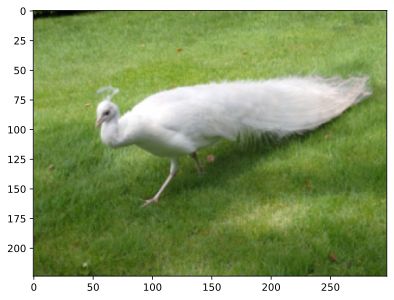

In [ ]:
plt.imshow((photo_tensor + delta)[0].detach().numpy().transpose(1,2,0))

**Et le bruit l'ayant transformée en avion de ligne pour le modèle ResNet50 :**

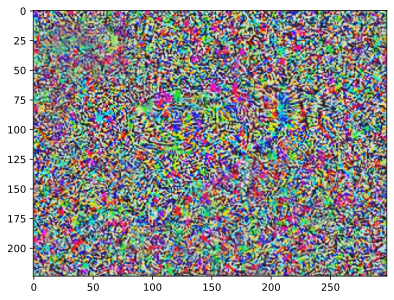

In [ ]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

La facilité de ces attaques soulève une question évidente : est-il possible de former des classificateurs d'apprentissage profond qui résistent d'une manière ou d'une autre à de telles attaques ? La réponse courte à cette question est « oui », mais, notamment, sans atteindre les performances que nous obtenons avec des méthodes d'apprentissage profond « standard ».

## Robustesse face aux attaques adverses et entraînement

Considérons de manière plus formalisée ces attaques contre les classifieurs de deep learning, et le challenge d'entrainer ou modifier les classificateurs existants de sorte à les rendre plus résistants à ces attaques.



### Bref examen : risque, données d'entraînement et de test
Pour commencer, nous pouvons considérer plus formellement la notion traditionnelle de risque telle qu'elle est utilisée dans l'apprentissage automatique. Le risque d'un classificateur est sa perte attendue dans le cadre de la distribution réelle des échantillons, i.e.
\begin{equation}
R(h_\theta) = \mathbf{E}_{(x,y)\sim\mathcal{D}}[\ell(h_\theta(x)),y)]
\end{equation}

où $\mathcal{D}$ désigne la distribution vraie sur les échantillons. En pratique, bien sûr, nous ne connaissons pas la distribution sous-jacente des données réelles, donc nous nous rapprochons de cette quantité en considérant un ensemble fini d'échantillons prélevés i.i.d. de $\mathcal{D}$,

\begin{equation}
D = \{(x_i,y_i) \sim \mathcal{D}\}, i=1,\ldots,m
\end{equation}


Et alors, nous considérons le risque empirique :

\begin{equation}
\hat{R}(h_\theta,D) = \frac{1}{|D|}\sum_{(x,y) \in D} \ell(h_\theta(x)),y).
\end{equation}

Le processus traditionnel de formation d'un algorithme d'apprentissage automatique est celui de la recherche de paramètres qui minimisent le risque empirique sur certains ensembles de formation désignés par $D_{\mathrm{train}}$ (ou éventuellement une version régularisée de cet objectif).  


\begin{equation}
\minimize_\theta \hat{R}(h_\theta, D_{\mathrm{train}}).
\end{equation}


Une fois que les paramètres $\theta$ ont été choisis sur la base de l'ensemble d'apprentissage $D_{\mathrm{train}}$, cet ensemble de données ne peut plus nous donner une estimation non biaisée du risque du classificateur résultant, et donc on effectue cette estimation sur un autre ensemble, $D_{\mathrm{test}}$ (qui contient également des points échantillonnés i.i.d. de la distribution sous-jacente vraie $\mathcal{D}$).Nous utiliserons, par suite, $\hat{R}(h_\theta, D_{\mathrm{test}})$  comme indicateur pour estimer le risque réel $R(h_{\theta})$.




### Risque adverse

Comme alternative au risque traditionnel, nous pouvons également considérer un risque adverse.

Il est identique au risque traditionnel, sauf qu'au lieu de subir la perte sur chaque point de $\ell(h_\theta(x), y)$, il souffre de la perte la plus mauvaise dans une région autour du point de l'échantillon, c'est-à-dire

\begin{equation}
R_{\mathrm{adv}}(h_\theta) = \mathbf{E}_{(x,y)\sim\mathcal{D}}\left[\max_{\delta \in \Delta(x)} \ell(h_\theta(x + \delta)),y) \right ]
\end{equation}

lorsque, pour l'exhaustivité, nous permettons explicitement que la région de perturbation $\Delta(x)$ puisse dépendre du point d'échantillon lui-même. En utilisant les exemples des sections précédentes, cela est nécessaire pour garantir que les perturbations respectent les bornes ultimes de l'image, mais elle peut aussi potentiellement encoder un grand nombre d'informations sémantiques sur les types de perturbations qui seraient autorisées pour chaque image.

Il y a aussi, naturellement, l'analogue empirique du risque adverse, qui ressemble exactement à ce que nous avons pris en considération dans les sections précédentes :


\begin{equation}
\hat{R}_{\mathrm{adv}}(h_\theta, D) = \frac{1}{|D|}\sum_{(x,y)\in D} \max_{\delta \in \Delta(x)} \ell(h_\theta(x + \delta)),y) .
\end{equation}

Cette quantité mesure essentiellement la perte empirique du pire cas du classificateur, si nous sommes en mesure de manipuler de manière antagoniste chaque entrée dans l'ensemble de données dans son ensemble admissible $\Delta(x)$.

Pourquoi préférer utiliser le risque adverse au lieu du risque traditionnel?

Si nous opérons vraiment dans un environnement adverse, où un adversaire est capable de manipuler les données en pleine connaissance du classificateur, alors cela fournira une estimation plus précise des performances attendues d'un classificateur.

Etre dans un tel environnement peut sembler peu probable dans la pratique, mais plusieurs tâches de classification (en particulier celles liées à la sécurité informatique) telles que la classification du spam, la détection de logiciels malveillants, la détection d'intrusions de réseau, etc., sont véritablement telles que les attaquants ont une incitation directe à tromper un classificateur.
Mais même si nous ne nous attendons pas à ce que l'environnement soit toujours adverse, certaines applications de l'apprentissage automatique semblent suffisamment importantes pour que nous souhaitions comprendre les performances du « pire cas » du classificateur, même s'il s'agit d'un événement improbable - exemple : la conduite autonome, où des travaux ont été menés pour étudier les moyens par lesquels les panneaux de signalisation pourraient être manipulés pour tromper intentionnellement un classificateur.

Cependant, il y a aussi un cas raisonnable où préférer le risque adverse empirique plutôt que le risque empirique traditionnel, _même si nous voulons en fin de compte minimiser le risque traditionnel_.
La raison de cela est qu'il est très difficile de prélever des échantillons i.i.d. de la vraie distribution sous-jacente. Toute procédure que nous utilisons pour collecter des données est une tentative empirique d'accéder à la véritable distribution sous-jacente, et peut ignorer certaines dimensions, en particulier si celles-ci apparaissent « évidentes » pour les humains.

Il y a eu beaucoup d'affirmations récentes selon lesquelles les algorithmes auraient [«dépassé les performances humaines» sur la classification des images](https://www.eetimes.com/document.asp?doc_id=1325712), en utilisant des classificateurs comme celui que nous avons vu en exemple.

Mais, comme l'exemple ci-dessus l'illustre, les algorithmes sont loin d'égaler les performances humaines s'ils ne peuvent même pas reconnaître qu'une image qui ressemble exactement à l'image originale, par quelque définition visuelle que ce soit, appartient en fait à la même classe.

Certains souteniennent que ces cas « ne devraient pas compter », parce qu'ils étaient spécifiquement conçus pour tromper l'algorithme en question, et peuvent ne pas correspondre à une image pouvant être vue en pratique. Mais des perturbations beaucoup plus simples telles que les translations et les rotations peuvent _également_ servir d'exemples adverses.

Le problème fondamental est que lorsque des revendications sont faites d'un «niveau humain» de performance par les systèmes de ML, elles signifient réellement «au niveau humain sur les données générées _exactement_ par le mécanisme d'échantillonnage utilisé dans cette expérience».

Mais les humains ne performent pas seulement sur une unique distribution d'échantillons ; les humains sont _étonnamment_ résilients aux changements dans l'environnement.

Ainsi, lorsqu'on déclare que les algorithmes d'apprentissage automatique «surpassent la performance humaine» (surtout lorsqu'on ajoute, commec'est fréquemment le cas, des affirmations selon lesquelles les algorithmes d'apprentissage profond associés «travaillent comme le cerveau humain»), cela conduit souvent à l'hypothèse implicite que les algorithmes seront _également_ résilients de la même manière.

Mais ce n'est pas le cas ; les algorithmes d'apprentissage profond sont _incroyablement_ fragiles, et les exemples adverses mettent ce fait à nu, d'une manière très évidente et intuitive. En d'autres termes, ne pouvons-nous pas au moins accepter de calmer ces prétentions à avoir atteint le « niveau humain », et de « travailler comme le cerveau humain » pour parler de systèmes qui sont aussi confiants dans le fait que la première image est un paon que dans le fait que la seconde image est un avion ?

In [ ]:
f,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow((photo_tensor)[0].detach().numpy().transpose(1,2,0))
ax[1].imshow((photo_tensor + delta)[0].detach().numpy().transpose(1,2,0))

### Entrainement de classificateurs robustes
Formation de classificateurs de formation robustes;

Considérons maintenant la tâche de former un classificateur robuste aux attaques adverses (ou de manière équivalente, une tâche qui minimise le risque adverse empirique). À l'instar du cas traditionnel, cela peut être écrit comme un problème d'optimisation.


\begin{equation}
\minimize_\theta \hat{R}_{\mathrm{adv}}(h_\theta, D_{\mathrm{train}})
\equiv \minimize_\theta \frac{1}{|D_{\mathrm{train}}|}\sum_{(x,y)\in D_{\mathrm{train}}} \max_{\delta \in \Delta(x)} \ell(h_\theta(x + \delta)),y) .
\end{equation}

**Il s'agit de la formulation d'optimisation min-max ou robuste de l'apprentissage adverse, et nous y reviendrons plusieurs fois au cours de ce tutoriel.**

Comme pour l'entrainement traditionnel, la façon dont nous résoudrons ce problème d'optimisation dans la pratique est via la descente stochastique de gradient sur $\theta$. C'est-à-dire que nous choisirons à plusieurs reprises un mini-batch $B \subseteq D_{\mathrm{train}}$, et que nous mettrons à jour $\theta$ en fonction de son gradient.

\begin{equation}
\theta := \theta - \frac{\alpha}{|B|} \sum_{(x,y)\in B} \nabla_\theta \max_{\delta \in \Delta(x)} \ell(h_\theta(x + \delta)),y).
\end{equation}


Mais comment calculer le gradient du terme intérieur maintenant, étant donné que la fonction interne elle-même contient un problème de maximisation ? La réponse est heureusement assez simple dans la pratique, et donnée par le [théorème de Danskin](https://en.wikipedia.org/wiki/Danskin%27s_theorem).

Ce théorème indique que le gradient de la fonction interne impliquant le terme de maximisation est simplement donné par le gradient de la fonction évaluée à ce maximum. En d'autres termes, en désignant par $\delta^\star$ l'optimum du problème d'optimisation interne

\begin{equation}
\DeclareMathOperator*{\argmax}{argmax}
\delta^\star = \argmax_{\delta \in \Delta(x)} \ell(h_\theta(x + \delta)),y)
\end{equation}

le gradient que nous cherchons est simplement donné par :


\begin{equation}
\nabla_\theta \max_{\delta \in \Delta(x)} \ell(h_\theta(x + \delta)),y) = \nabla_\theta \ell(h_\theta(x + \delta^\star)),y)
\end{equation}

(où, dans le côté droit, nous traitons $\delta^\star$ comme une quantité fixe, c'est-à-dire que nous ne nous inquiétons pas de sa dépendance à l'égard de $\theta$). Cela peut sembler « évident », mais c'est en fait un point assez subtil, et il n'est pas facile de montrer que ce résultat se maintient (après tout, la valeur obtenue de $\delta^\star$ dépend de $\theta$, il n'est donc pas évident que nous puissions le traiter comme indépendant de $\theta$ en prenant le gradient). Nous ne prouvons pas le théorème de Danskin ici, et nous noterons simplement que cette propriété nous rend la vie beaucoup plus facile.


Compte tenu de ce cadre, il y a une bonne interaction entre le défi de trouver un exemple adverse, et le processus d'entrainement d'un classificateur robuste. Plus précisément, le processus de descente de gradient sur le risque adverse empirique ressemblera à ce qui suit.



   1. Pour chaque $x,y \in B$, résoudre le problème de maximisation interne (c'est-à-dire calculer un exemple adverse)

\begin{equation}
  \delta^\star(s) = \argmax_{\delta \in \Delta(x)} \ell(h_\theta(x + \delta)),y)
  \end{equation}

   2. Calculer le gradient du risque adverse empirique, et mettre à jour $\theta$


  \begin{equation}
  \theta := \theta - \frac{\alpha}{|B|} \sum_{(x,y)\in B} \nabla_\theta \ell(h_\theta(x + \delta^\star(x))),y).
  \end{equation}



En d'autres termes, nous calculons itérativement des exemples adverses, puis mettons à jour le classificateur en nous basant non pas sur les points de données originaux, mais sur ces exemples adverses.

Cette procédure est connue sous le nom d'« entrainement adverse » dans la littérature d'apprentissage profond, et (si elle est faite correctement - davantage bientot sur ce sujet) c'est l'une des méthodes empiriques les plus efficaces que nous ayons pour l'entrainement de modèles robustes contre les attaques adverses, bien que quelques mises en garde vaillent la peine d'être mentionnées.

Tout d'abord, il convient de noter que nous n'effectuons _en fait_ jamais de descente de gradient sur le véritable risque adverse empirique, précisément parce que nous ne pouvons en général pas résoudre le problème de maximisation interne de manière optimale.

Plus précisément, la maximisation interne, si elle est faite par descente de gradient comme nous l'avons fait plus haut, est un problème d'optimisation non convexe, où nous pouvons au mieux trouver un optimum local, en utilisant des techniques telles que la descente du gradient.

Et comme le théorème de Danskin, par exemple, ne s'applique en théorie que lorsque le problème de maximisation interne est résolu exactement, cela pose apparemment problème à de tels approximateurs.

Dans la pratique, cependant, si le problème d'optimisation interne est « suffisamment bien résolu », alors cette stratégie fonctionne bien.

Elle est toutefois totalement dépendante de la façon dont ce problème d'optimisation interne est effectivement résolu; si seule une stratégie approximative et pauvre est utilisée pour résoudre le problème de maximisation interne, alors il y a de bonnes chances qu'une stratégie d'optimisation interne un peu plus exhaustive se révèle une attaque efficace. C'est pourquoi les meilleures stratégies actuelles sont celles qui résolvent explicitement ce problème d'optimisation interne (même approximativement) aussi bien que possible, rendant aussi difficile que possible (même si pas impossible) pour une stratégie ultérieure d'« optimiser » la robustesse entraînée.

Deuxièmement, bien qu'en théorie on puisse prendre juste la pire perturbation  comme point où calculer le gradient, dans la pratique, cela peut provoquer des osscilations du processus d'entraînement, et il est souvent préférable d'incorporer des perturbations multiples avec différentes initialisations aléatoires et potentiellement également un gradient basé sur le point initial sans perturbation.

Enfin, nous devrions noter que certaines méthodes d'entraînement robustes (en particulier, celles basées sur les limites du problème de maximisation interne), ne nécessitent _pas_ en fait de trouver itérativement un point adverse et ensuite d'optimiser; au lieu de cela, elles produisent une forme fermée liée à la maximisation interne, qui peut être résolue de manière non itérative. Nous examinerons davantage ces approches dans les sections suivantes.




### Commentaire final

Nous voulons faire un dernier commentaire, sur la valeur de la formulation robuste d'optimisation de la robustesse adverse. Il est important de souligner que **chaque attaque et chaque défense adverse sont une méthode permettant de résoudre approximativement le problème de maximisation intérieure et/ou de minimisation externe respectivement**. Même les articles qui ne s'expriment pas de cette manière, tentent de résoudre ces problèmes (bien qu'avec certaines différences potentielles, par exemple en considérant directement une perte différente de la perte d'entropie croisée, telle que la perte 0/1).

À notre avis, un défi notable avec le domaine est que de nombreux journaux présentent une attaque ou une défense en termes de _méthode_ qu'il utilise, plutôt que comme le _problème_ (c'est-à-dire, problème d'optimisation) qu'il résout. C'est ainsi que nous obtenons de nombreux noms différents pour de nombreuses stratégies différentes qui considèrent toutes une variante mineure de l'optimisation ci-dessus, comme considérer différentes limites de normes dans le terme $\Delta(x)$, en utilisant différentes procédures d'optimisation pour résoudre le problème de maximisation interne, ou en utilisant des techniques apparemment très extravagentes pour se défendre contre les attaques, qui fréquemment ne semblent pas être clairement liées à la formulation d'optimisation. S'il est certainement possible que de telles méthodes s'avèrent plus efficaces que les stratégies les plus connues que nous ayions, l'historique n'est cependant pas bon.

avec l'ensemble de ces éléments à l'esprit, l'ordre du jour des prochains chapitres de ce tutoriel devrait être clair. Dans le chapitre 2, nous allons d'abord effectuer une digression pour montrer comment toutes ces questions fonctionnent dans le cas des modèles linéaires; peut-être sans surprise, dans le cas linéaire, le problème de maximisation interne dont nous avons discuté peut être résolu exactement (ou très étroitement lié par borne supérieure), et nous pouvons effectuer des affirmations très fortes sur la performance de ces modèles dans les contextes adverses. Ensuite, au chapitre 3, nous reviendrons sur le monde des réseaux de neurones profonds, et examinerons le problème de maximisation interne, en nous concentrant sur les trois classes générales d'approches qui peuvent être appliquées: 1) les bornes inférieures (c'est-à-dire la construction de l'exemple adverse), 2) les solutions exactes (via l'optimisation combinatoire), 3) les limites supérieures (généralement avec une stratégie mieux traitable). Dans le chapitre 4, nous nous penchons ensuite sur le problème de l'entrainement des modèles adverses, qui impliquent généralement soit un entrainement adverse utilisant la borne inférieure, soit une formation robuste «certifiée» impliquant les limites supérieures (l'entraînement adverse utilisant les solutions combinatoires exactes n'a pas encore été prouvé comme possible). Enfin, le chapitre 5 revient à certaines des questions d'ensemble de ce chapitre, et plus encore : nous discuterons ici de la valeur de la robustesse adverse au-delà des justifications « de sécurité » typiques; au lieu de cela, nous considérons la robustesse adverse dans le contexte de la régularisation, de la généralisation et de la signification des représentations apprises.
